In [1]:
#Setup for receiving other modules
import sys;

mathematics_source_path="/home/mkr/mathematics/"
sys.path.insert(0, mathematics_source_path + 'source')
sys.path = list(set(sys.path))

In [2]:
# Demonstration of Sampling Importance Resampling (SIR)
from sage.symbolic.integration.integral import definite_integral
from sage.symbolic.integration.integral import indefinite_integral
import numpy as np
import montecarlo.estimator as monte
import montecarlo.average_sample as mas

print(mas.AverageSample(lambda : 1, 100).calculate())

1.0


In [3]:
# Define variables
var('x,y')

(x, y)

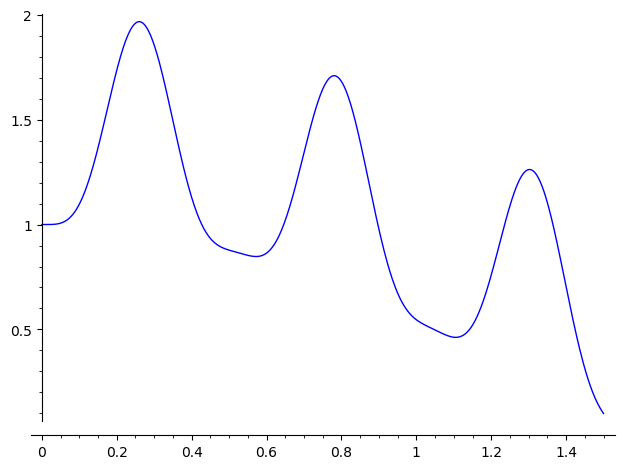

In [4]:
# Define the function we are going to integrate
f=cos(x)+(sin(6*x))^4

domainF_Start=0
domainF_End=1.5
domainF_Size=domainF_End-domainF_Start

plot(f,x,domainF_Start,domainF_End)

('PDF', x |--> -0.533333333333333*x + 1.06666666666667)
('PDF integrates to', 1.0)


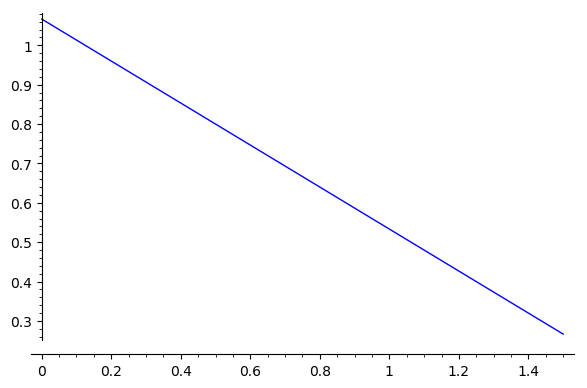

In [17]:
# Define a simple Probability Density Function (PDF)
# The PDF should be treated as 0 outside of domainF
# NOTE: extension(0) adds two pieces, x=0 in (-inf,domainF_Start) and x=0 in (domainF_End,+inf)
#pdf(x)=SR(1/domainF_Size)
pdf(x)= (-x+2) / 1.875

print("PDF", pdf)
print("PDF integrates to", pdf.integral(x, domainF_Start, domainF_End))

plot(pdf,x,domainF_Start,domainF_End)

('CDF', x |--> -0.26666666666666666*x^2 + 1.0666666666666667*x)
('PinY', -0.26666666666666666*x^2 + 1.0666666666666667*x)
('P', -1/2*sqrt(-15*x + 16) + 2)


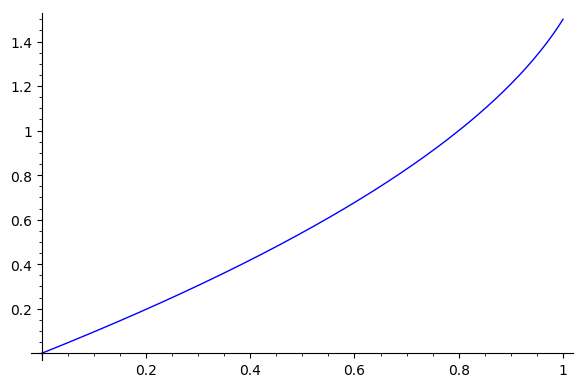

In [18]:
# Define the Probability function P from the PDF through CDF Inversion
cdf=pdf.integral(x)
PinY = cdf(x) - cdf(domainF_Start)
P = solve(x == PinY(y), y)[0].rhs()
print("CDF", cdf)
print("PinY", PinY)
print("P", P)
plot(P,x,0,1)

In [22]:
# Draw M samples from P
samplesCountM = 1000
samplesX = [P(random()) for i in range(samplesCountM)]

# Calculate the weights to associate to the sample points we produced. These weights are going to be our new probabilities
samplesValues = [f(xi)/pdf(xi) for xi in samplesX]
samplesWeightsNormalizationFactor = sum(samplesValues[i] for i in range(samplesCountM))
samplesWeights = [samplesValues[i] / samplesWeightsNormalizationFactor for i in range(samplesCountM)]

# Now we Re-Sample, but this time we Draw N samples from a new "distribution" made using the Sample Weights
sir_piecewise_P = [[samplesX[i], samplesWeights[i]] for i in range(samplesCountM)]
sir_piecewise_P = sorted(sir_piecewise_P, key=lambda x: x[1])
sir_piecewise_pdf = [[samplesX[i], samplesWeights[i]] for i in range(samplesCountM)]
sir_piecewise_pdf = sorted(sir_piecewise_pdf, key=lambda x: x[0])

# The PDF must integrate to 1 - Calculate the normalization factor so that if we were to Monte Carlo this function it would yield 1
# NOTE: this step is mine, it makes sense but I am not sure it's the way the paper would do this
normalizationFactor = domainF_Size / len(sir_piecewise_pdf)
for entry in sir_piecewise_pdf:
    entry[1] = entry[1] / normalizationFactor
    
# functions to sample from piecewise P and PMF
def SIR_P(x, piecewiseP):
    index = 0
    accum = 0
    while(index < len(piecewiseP)):
        accum = accum + piecewiseP[index][1]
        if(x < accum):
            return piecewiseP[index][0]
        index = index + 1
    return 0

def SIR_pdf(x, piecewisePDF):
    index = 0
    while(index < len(piecewisePDF)):
        if(x < piecewisePDF[index][0]):
            return piecewisePDF[index][1]
        index = index + 1
    return piecewisePDF[len(piecewisePDF)-1][1]

In [8]:
def VerbatimSIR_P(randomX, g, base_pdf, base_P):
    # Draw M samples from P
    samplesCountM = 200
    samplesX = [base_P(x=random()) for i in range(samplesCountM)]

    # Calculate the weights to associate to the sample points we produced. These weights are going to be our new probabilities
    samplesValues = [g(x=xi)/base_pdf(xi) for xi in samplesX]
    samplesWeightsNormalizationFactor = sum(samplesValues[i] for i in range(samplesCountM))
    samplesWeights = [samplesValues[i] / samplesWeightsNormalizationFactor for i in range(samplesCountM)]

    sir_P = [[samplesX[i], samplesWeights[i]] for i in range(samplesCountM)]
    sir_P = sorted(sir_P, key=lambda x: x[1])
    
    # Finally, resample
    x=randomX
    index = 0
    accum = 0
    while(index < len(sir_P)):
        accum = accum + sir_P[index][1]
        if(x < accum):
            return sir_P[index][0]
        index = index + 1
    return sir_P[len(Pairs) - 1][0]

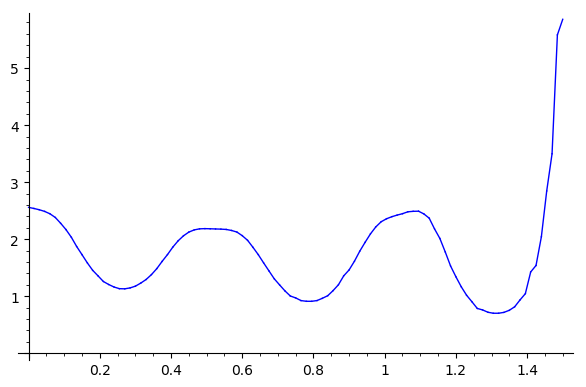

In [20]:
# Plot the SIR PDF
plotSteps = 100
plotResult = line([(0,0),(0,0)])
for loopX in np.arange(domainF_Start, domainF_End, domainF_Size / plotSteps):
    x1 = loopX
    x2 = loopX + domainF_Size / plotSteps
    y1 = SIR_pdf(x1, sir_piecewise_pdf)
    y2 = SIR_pdf(x2, sir_piecewise_pdf)
    plotResult = plotResult + line([(x1,y1),(x2,y2)])
plotResult.plot()

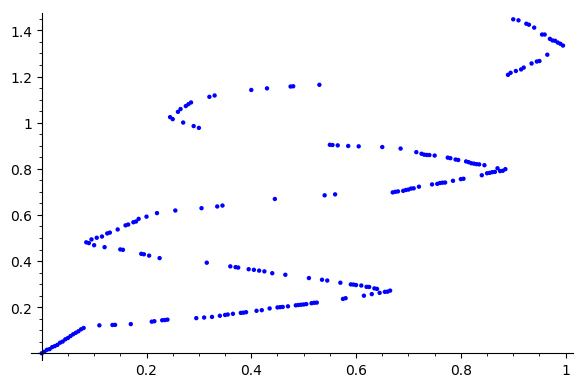

In [10]:
# Plot the SIR P
plotSteps = 200
plotResult = line([(0,0),(0,0)])
for loopX in np.arange(0, 1, 1 / plotSteps):
    x = loopX
    y = SIR_P(x, sir_piecewise_P)
    plotResult = plotResult + point([(x,y)])
plotResult.plot()

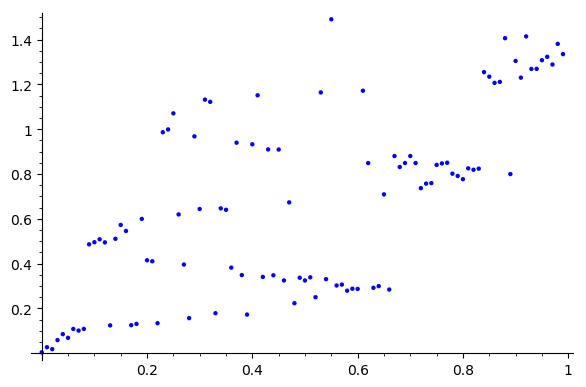

In [11]:
# Plot the Verbatim SIR
plotSteps = 100
plotResult = line([(0,0),(0,0)])
for loopX in np.arange(0, 1, 1 / plotSteps):
    x = loopX
    y = VerbatimSIR_P(x, f,pdf,P)
    plotResult = plotResult + point([(x,y)])
plotResult.plot()

In [13]:
def SIR_SampleFOverPDF():
    uniformXi = random()
    xi = SIR_P(uniformXi, sir_piecewise_P)
    return f(xi)/SIR_pdf(xi, sir_piecewise_pdf)

def VerbatimSIR_SampleFOverPDF():
    uniformXi = random()
    xi = VerbatimSIR_P(uniformXi,f,pdf,P)
    return f(xi)/pdf(xi)

def SampleFOverPDF():
    uniformXi = random()
    xi = P(uniformXi)
    return f(xi)/pdf(xi)

# Run the monte carlo estimator
var('x,y')
samplesCountT = 100
V = definite_integral(f,x,domainF_Start,domainF_End)
E3 = monte.Estimator(lambda : f(random() * domainF_Size + domainF_Start), domainF_Start, domainF_End, samplesCountT).integrate()
E1 = mas.AverageSample(SIR_SampleFOverPDF, samplesCountT).calculate()
E2 = mas.AverageSample(SampleFOverPDF, samplesCountT).calculate()
E4 = mas.AverageSample(VerbatimSIR_SampleFOverPDF, samplesCountT).calculate()
print("SIR", E1)
print("IS", E2)
print("Monte Carlo", E3)
print("SIR2", E4)
print("Truth", V)

('SIR', 1.81633017689228)
('IS', 1.52214232365842)
('Monte Carlo', 1.48354761054887)
('SIR2', 1.87427546834377)
('Truth', 1.5861206070245246)
